2018312856 Ko Sungwon - DeepFake Classification Assginment.

1. Low Quality data - face2face dataset / ResNet18
2. Low Quality data - face2face dataset / EfficientNetB0
3. Low Quality data - NeuralTexture dataset / ResNet18
4. Low Quality data - NeuralTexture dataset / EfficientNetB0

5. High Quality data - face2face dataset / ResNet18
6. High Quality data - face2face dataset / EfficientNetB0
7. High Quality data - NeuralTexture dataset / ResNet18
8. High Quality data - NeuralTexture dataset / EfficientNetB0


-----------------------------------------------------------------
This file is for 5. High Quality data - face2face dataset / ResNet18
My codes are based on content of the book <딥러닝 파이토치 교과서> - 서지영 지음 which I have.

In [1]:
# 필요한 라이브러리 호출 / 디바이스 확인, 할당
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있게 해주는 패키지
from torchsummary import summary
from sklearn.metrics import classification_report

import os
import cv2
import time
import glob
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import copy
from matplotlib import pyplot as plt
import numpy as np

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')

print('CUDA 사용 가능 여부: ', USE_CUDA)
print('현재 사용 device: ', device)
print('CUDA Index', torch.cuda.current_device())
print('GPU 이름: ', torch.cuda.get_device_name())
print('GPU 개수: ', torch.cuda.device_count())

CUDA 사용 가능 여부:  True
현재 사용 device:  cuda:0
CUDA Index 0
GPU 이름:  GeForce GTX 1650 Ti
GPU 개수:  1


In [2]:
# 훈련/검증/테스트 데이터 경로 설정
train_path = '../DFdetection_HW3/DF_data/High_Quality/f2f_data/train'
val_path = '../DFdetection_HW3/DF_data/High_Quality/f2f_data/val'
test_path = '../DFdetection_HW3/DF_data/High_Quality/f2f_data/test'

In [3]:
# 이미지 데이터셋 나누기

import shutil

def make_class_folders(target_path):
    real_dir = os.path.join(target_path, 'real')
    fake_dir = os.path.join(target_path, 'fake')
    os.mkdir(real_dir)
    os.mkdir(fake_dir)


    file_name_list = os.listdir(target_path)
    for file_name in file_name_list:
        if file_name == 'fake' or file_name == 'real':
            pass
        else:
            src = os.path.join(target_path, file_name)
        
            if 'real' in file_name:
                dst = os.path.join(real_dir, file_name)
            else:
                dst = os.path.join(fake_dir, file_name)
        
            shutil.move(src, dst)
    
    print('class folders generated!')
    print('{} real images in real folder'.format(len(os.listdir(real_dir))))
    print('{} fake images in fake folder'.format(len(os.listdir(fake_dir))))
    print('-'*20)

In [4]:
# print('processing train folder')
# make_class_folders(train_path)

# print('processing validation folder')
# make_class_folders(val_path)

# print('processing test folder')
# make_class_folders(test_path)

In [5]:
# 이미지 데이터 전처리 방법 정의
data_path = train_path

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose(
    [transforms.Resize([256, 256]),  # 이미지의 크기를 256x256으로 조정
     transforms.RandomResizedCrop(224), # 이미지 데이터셋 확장. 랜덤한 비율로 자른 후 224x224으로 맞춘다.
     transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집는다.
     transforms.ToTensor(), # 이미지를 텐서로 변환
     transforms.Normalize(mean, std)
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

1200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

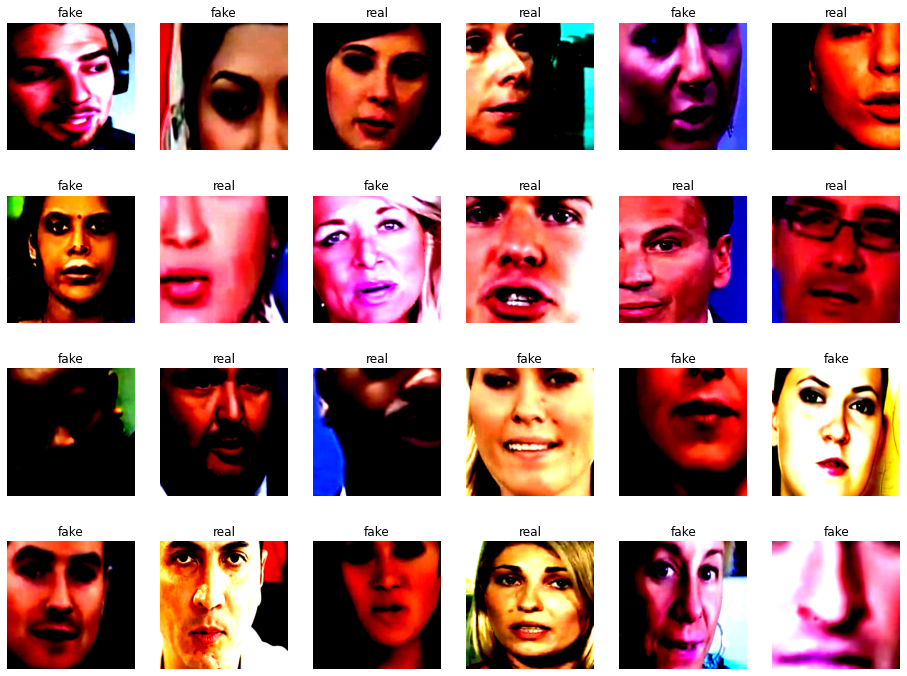

In [6]:
# 학습에 사용될 이미지 출력
import warnings
warnings.filterwarnings('ignore')

samples, labels = iter(train_loader).next()
classes = {0: 'fake', 1: 'real'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0))) # 원래 samples[i] = (3, 224, 224)꼴임. 그러나 imshow로 출력하려면..(224, 224, 3 꼴로 바꿔줘야 함)

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [7]:
resnet18 = models.resnet18(pretrained=True) # 사전학습된 가중치를 사용하겠음!

#ResNet18: 50개의 계층으로 구성된 합성곱 신경망. 입력 제약이 크고, RAM이 충분하지 않으면 훈련 속도가 느릴 수 있다.
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False    # conv 층, pooling 층 -> 파라미터에 대해서 gradient 계산하지 않고, update도 없다.

set_parameter_requires_grad(resnet18)
#17. ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)

#18. 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

#19. 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
model.to(device)
summary(model, input_size = (3, 224, 224))

fc.weight tensor([[ 0.0197, -0.0215,  0.0367,  ..., -0.0213, -0.0088, -0.0258],
        [-0.0263,  0.0236,  0.0287,  ..., -0.0180, -0.0317, -0.0099]])
fc.bias tensor([ 0.0358, -0.0069])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 5

In [8]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)

optimizer = optim.Adam(params_to_update) # 어떤 파라미터들이 업데이트 되는지 확인/전달

	 fc.weight
	 fc.bias


In [9]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 100, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*inputs.size(0) 
            running_corrects += torch.sum(preds==labels.data)

        epoch_loss = running_loss/len(dataloaders.dataset) #평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

        print('Loss: {:4f} Acc: {:4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))
    torch.save(best_model_wts, os.path.join('../DFdetection_HW3/models/', 'HQ_f2f_ResNet_best.pth'))
    return acc_history, loss_history # 모델의 정확도, 오차 기록을 반환

In [10]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실함수 지정
# train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

In [11]:
# 테스트 데이터 호출 및 전처리
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]
)
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

398


In [14]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    full_labels = []
    full_preds = []
    

    model.load_state_dict(torch.load('../DFdetection_HW3/models/HQ_f2f_ResNet_best.pth'))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad(): # auto-grad 사용하지 않음. 그냥 순전파만 시킨다!
            outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        running_corrects += preds.eq(labels).int().sum()

        labels = labels.detach().cpu().numpy()        
        preds = preds.detach().cpu().numpy()
        for i in range(len(labels)):
            full_labels.append(labels[i])
            full_preds.append(preds[i])

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
    acc_history.append(epoch_acc.item())
    print()

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    print(classification_report(full_labels,full_preds))

    return acc_history

In [15]:
# 테스트 데이터를 평가 함수에 적용
test_acc_hist = eval_model(resnet18, test_loader, device)

Acc: 0.7312

Test complete in 0m 3s
Best Acc: 0.731156
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       199
           1       0.70      0.81      0.75       199

    accuracy                           0.73       398
   macro avg       0.74      0.73      0.73       398
weighted avg       0.74      0.73      0.73       398



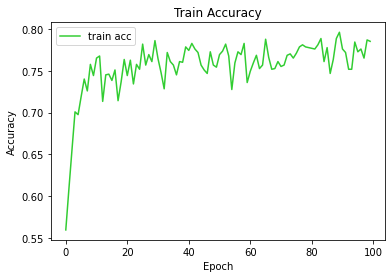

In [ ]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist, label = 'train acc', color = 'limegreen')
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

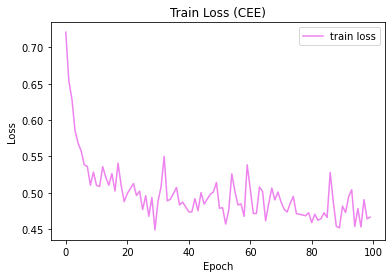

In [ ]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist, label = 'train loss', color = 'violet')
plt.title('Train Loss (CEE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()